# Import Libraries

In [1]:
# Mengunduh lbraries yang dibutuhkan
%pip install transformers
%pip install Sastrawi
%pip install emoji

# Mengunduh / clone repository
!git clone https://github.com/rifqimaruf/indonlu.git

Note: you may need to restart the kernel to use updated packages.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 209.7/209.7 kB 4.1 MB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Cloning into 'indonlu'...
remote: Enumerating objects: 500, done.
remote: Counting objects: 100% (184/184), done.
remote: Compressing objects: 100% (74/74), done.
remote: Total 500 (delta 115), reused 139 (delta 110), pack-reused 316 (from 1)
Receiving objects: 100% (500/500), 9.45 MiB | 27.42 MiB/s, done.
Resolving deltas: 100% (235/235), done.


In [2]:
# libraries untuk data processing
import pandas as pd
import numpy as np
import random
import re
from sklearn.model_selection import train_test_split, StratifiedKFold 
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report
from IPython.display import display, HTML
from collections import defaultdict

# Melakukan visualisasi
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib as mpl
from wordcloud import WordCloud

# Natural Language Processing Libraries
import nltk
from nltk.probability import FreqDist
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer
from Sastrawi.Stemmer.StemmerFactory import StemmerFactory
from Sastrawi.StopWordRemover.StopWordRemoverFactory import StopWordRemoverFactory
from collections import defaultdict
import emoji

# Melaukan Handling Imbalance Dataset
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as imPipeline
from imblearn.over_sampling import RandomOverSampler

# Deep Learning libraries untuk Model IndoBERT
import torch
import torch.nn.functional as F
from torch.utils.data import Subset, DataLoader
from torch import optim
from tqdm import tqdm
from torch.cuda.amp import GradScaler, autocast
from torch.optim.lr_scheduler import OneCycleLR


# Transformers libraries untuk IndoBert
from transformers import BertForSequenceClassification, BertConfig, BertTokenizer, BertModel

import time
import warnings
warnings.filterwarnings("ignore")

In [3]:
# Menghapus folder yang sudah ada 
import shutil
# shutil.rmtree('/kaggle/working/indonlu')

# Data Loading

In [4]:
display(HTML("<h2> Membaca Data</h2>\n"))
# Membaca dataset Pemilu dan BBM
pemilu_df = pd.read_csv("/kaggle/input/pemilu-kp/pemilu_data_preprocessed.tsv", delimiter='\t' )
bbm_df = pd.read_csv("/kaggle/input/pemilu-kp/bbm_data_preprocessed.tsv", delimiter='\t')

# Menampilkan beberapa baris dari dataframe
print("Pemilu DataFrame:")
display(pemilu_df.head())

print("BBM DataFrame:")
display(bbm_df.head())

Pemilu DataFrame:


,text,sentiment
0,barusan lihat tulis belakang truk rela injek k...,neutral
1,her lho miss kevin sama keven rebut gimbot iya...,neutral
2,iya rep tahu aku kelas sd ehh block,neutral
3,aku mohon tepat janji penantiancintaeps,neutral
4,bukan ria nk kahwin ikut gatal celah kangkang ...,neutral


BBM DataFrame:


,text,sentiment
0,uang bukti dulu kalau ngetik hy gaes bagus mor...,neutral
1,kayang kaya talaga paikutin gong itong bbm ka...,neutral
2,bajingany mna om apa obral ikn apa apa bo...,negative
3,kamu bicara lahir pas jaman orde baru jadi ert...,negative
4,gaji besar bukan tunjang kerja baik pertamina...,negative


# Data Exploration

In [5]:
# 1. Menampilkan ringkasan informasi umum DataFrame 
display(HTML("<h2> Ringkasan Informasi Data Pemilu</h2>\n"))
pemilu_df.info(),
print("===================================================")
display(HTML("<h2> Ringkasan Informasi Data BBM</h2>"))
bbm_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 42110 entries, 0 to 42109
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   text       42110 non-null  object
 1   sentiment  42110 non-null  object
dtypes: object(2)
memory usage: 658.1+ KB


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7022 entries, 0 to 7021
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   text       7022 non-null   object
 1   sentiment  7022 non-null   object
dtypes: object(2)
memory usage: 109.8+ KB


In [6]:
# 2. Donat Plot
# Fungsi Donat Plot
def donut(sizes, ax, angle=90, labels=None,colors=None, explode=None, shadow=None):

    # Plot
    ax.pie(sizes, colors = colors, labels=labels, autopct='%.1f%%', 
           startangle = angle, pctdistance=0.8, explode = explode, 
           wedgeprops=dict(width=0.4), shadow=shadow)

    # Formatting
    plt.axis('equal')  
    plt.tight_layout()

In [7]:
# Argument plot untuk Pemilu
sizes_pemilu = pemilu_df.sentiment.value_counts()
labels_pemilu = ['Tweet Netral', 'Tweet Negatif', 'Tweet Positif']
colors_pemilu = ['lightgreen', 'lightskyblue', 'lightcoral']
explode_pemilu = (0, 0, 0)

# Argument plot untuk BBM
sizes_bbm = bbm_df.sentiment.value_counts()
labels_bbm = ['Tweet Netral', 'Tweet Negatif', 'Tweet Positif']
colors_bbm = ['lightgreen', 'lightskyblue', 'lightcoral']
explode_bbm = (0, 0, 0)

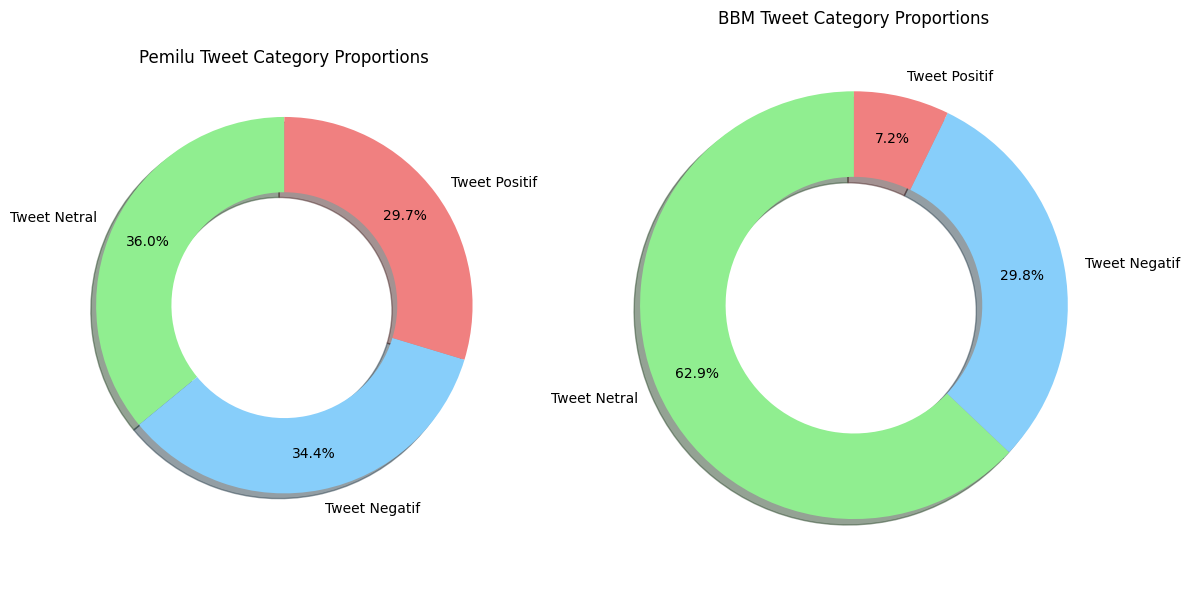

In [8]:
# Membuat Figure dan Axis untuk dua subplot
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))

# Plot donat untuk Pemilu
donut(sizes_pemilu, ax1, 90, labels_pemilu, colors=colors_pemilu, explode=explode_pemilu, shadow=True)
ax1.set_title('Pemilu Tweet Category Proportions')

# Plot donat untuk BBM
donut(sizes_bbm, ax2, 90, labels_bbm, colors=colors_bbm, explode=explode_bbm, shadow=True)
ax2.set_title('BBM Tweet Category Proportions')

# Menampilkan plot
plt.tight_layout()
plt.show()
     

In [9]:
# 3. Mengecek WordFrequency dan Wordcloud
# Fungsi untuk membuat corpus dari kolom teks
def make_corpus(column):
    corpus_list = [word for text in column for word in text.split(' ')]
    corpus = ' '.join(corpus_list)
    return re.sub(' +', ' ', corpus)  # Mengganti spasi ganda dengan satu spasi

# Fungsi untuk menghitung frekuensi kata
def word_freq(corpus, top=5):
    tokenized_word = word_tokenize(corpus)
    freqdist = FreqDist(tokenized_word)
    df = pd.DataFrame(freqdist.most_common(top), columns=['word', 'freq'])
    return df

In [10]:
# Membuat corpus dan menghitung frekuensi untuk kedua DataFrame
corpus_pemilu = make_corpus(pemilu_df['text'])
corpus_bbm = make_corpus(bbm_df['text'])

corpus_freq_pemilu = word_freq(corpus_pemilu, top=20)
corpus_freq_bbm = word_freq(corpus_bbm, top=20)

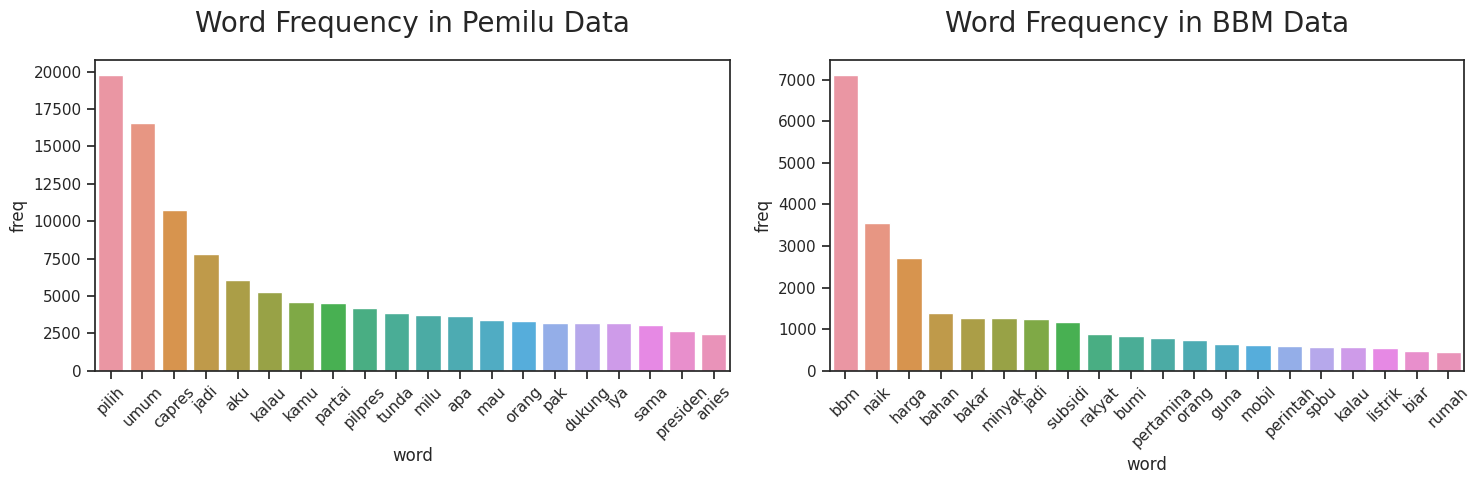

In [11]:
# Mengatur parameter visualisasi
plt.style.use('default')
sns.set(style='ticks', palette='Set2')
mpl.rcParams['axes.titlesize'] = 20
mpl.rcParams['axes.titlepad'] = 20

# Membuat figure dengan dua subplot (dua axis)
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

# Plot frekuensi kata untuk data Pemilu
sns.barplot(x='word', y='freq', data=corpus_freq_pemilu, ax=ax1)
ax1.set_title('Word Frequency in Pemilu Data')
ax1.tick_params(axis='x', rotation=45)

# Plot frekuensi kata untuk data BBM
sns.barplot(x='word', y='freq', data=corpus_freq_bbm, ax=ax2)
ax2.set_title('Word Frequency in BBM Data')
ax2.tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

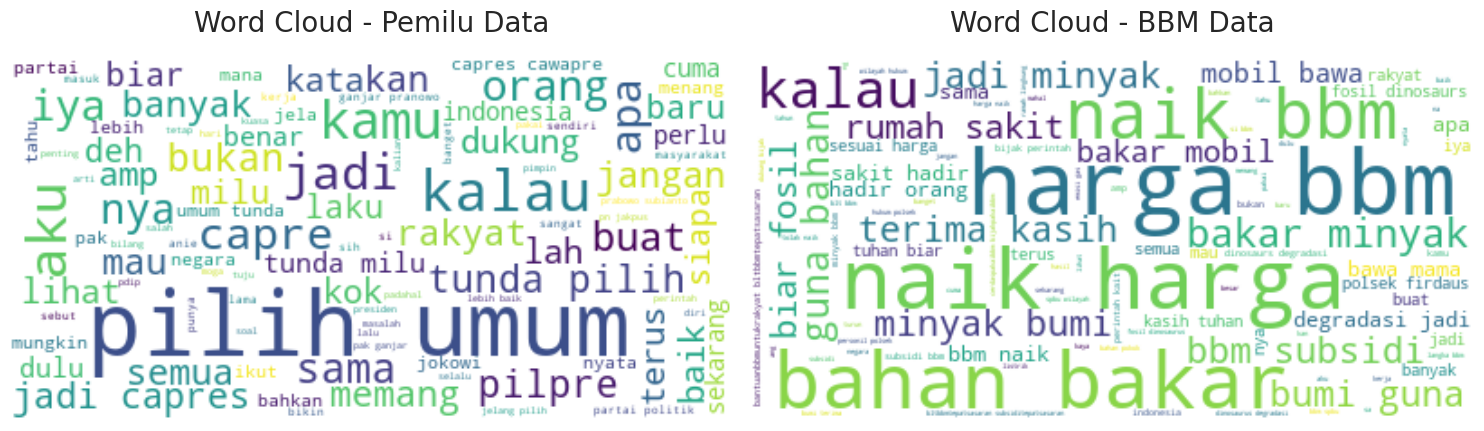

In [12]:
# Membuat WordCloud untuk kedua corpus
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

# WordCloud untuk corpus Pemilu
wordcloud_pemilu = WordCloud(max_font_size=50, max_words=100, background_color="white").generate(corpus_pemilu)
ax1.imshow(wordcloud_pemilu, interpolation="bilinear")
ax1.axis("off")
ax1.set_title('Word Cloud - Pemilu Data')

# WordCloud untuk corpus BBM
wordcloud_bbm = WordCloud(max_font_size=50, max_words=100, background_color="white").generate(corpus_bbm)
ax2.imshow(wordcloud_bbm, interpolation="bilinear")
ax2.axis("off")
ax2.set_title('Word Cloud - BBM Data')

plt.tight_layout()
plt.show()

In [13]:
# 4. Mengecek duplikasi value
pemilu_df.duplicated().sum(), bbm_df.duplicated().sum()

(309, 671)

In [14]:
# 5. Menampilkan ukuran baris dan kolom DataFrame
pemilu_df.shape, bbm_df.shape

((42110, 2), (7022, 2))

# Train and Modelling

In [15]:
tokenizer = BertTokenizer.from_pretrained('indobenchmark/indobert-base-p1')
config = BertConfig.from_pretrained('indobenchmark/indobert-base-p1')
config.num_labels = 3 
model = BertForSequenceClassification.from_pretrained('indobenchmark/indobert-base-p1', config=config)

tokenizer_config.json:   0%|          | 0.00/2.00 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/229k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/1.53k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/498M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [16]:
# Fungsi untuk menyiapkan dataset dan label
def prepare_dataset_and_labels(dataset):
    all_labels = np.array([dataset[i][1] for i in range(len(dataset))])
    all_texts = [dataset[i][0] for i in range(len(dataset))]
    return all_texts, all_labels

# Fungsi untuk mengukur evaluasi matric
def compute_metrics(preds, labels):
    precision = precision_score(labels, preds, average='weighted')
    recall = recall_score(labels, preds, average='weighted')
    f1 = f1_score(labels, preds, average='weighted')
    cm = confusion_matrix(labels, preds)
    return precision, recall, f1, cm


In [17]:
class DocumentSentimentDataset(torch.utils.data.Dataset):
    LABEL2INDEX = {"neutral": 0, "positive": 1, "negative": 2}

    def __init__(self, dataset_path, tokenizer, lowercase=False):
        self.data = self.load_dataset(dataset_path)
        self.tokenizer = tokenizer
        self.lowercase = lowercase

    def load_dataset(self, path):
        df = pd.read_csv(path, sep='\t')
        df.columns = ['text', 'sentiment']
        df['sentiment'] = df['sentiment'].apply(lambda lab: self.LABEL2INDEX[lab])
        return df

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        text = self.data.iloc[idx]['text']
        sentiment = self.data.iloc[idx]['sentiment']
        if self.lowercase:
            text = text.lower()
        encoding = self.tokenizer.encode_plus(
            text,
            add_special_tokens=True,
            return_attention_mask=True,
            padding='max_length',
            max_length=512,
            truncation=True,
            return_tensors='pt'
        )
        return encoding['input_ids'].squeeze(), sentiment


In [18]:
# Function to plot the history for a given dataset
def plot_history(history, title):
    epochs = range(1, len(history['train_loss']) + 1)

    plt.figure(figsize=(16, 10))

    # Loss
    plt.subplot(2, 2, 1)
    plt.plot(epochs, history['train_loss'], label='Train Loss')
    plt.plot(epochs, history['val_loss'], label='Validation Loss')
    plt.title('Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    # Accuracy
    plt.subplot(2, 2, 2)
    plt.plot(epochs, history['train_accuracy'], label='Train Accuracy')
    plt.plot(epochs, history['val_accuracy'], label='Validation Accuracy')
    plt.title('Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    # Precision
    plt.subplot(2, 2, 3)
    plt.plot(epochs, history['train_precision'], label='Train Precision')
    plt.plot(epochs, history['val_precision'], label='Validation Precision')
    plt.title('Precision')
    plt.xlabel('Epochs')
    plt.ylabel('Precision')
    plt.legend()

    # Recall and F1-Score
    plt.subplot(2, 2, 4)
    plt.plot(epochs, history['train_recall'], label='Train Recall')
    plt.plot(epochs, history['val_recall'], label='Validation Recall')
    plt.plot(epochs, history['train_f1'], label='Train F1-Score')
    plt.plot(epochs, history['val_f1'], label='Validation F1-Score')
    plt.title('Recall and F1-Score')
    plt.xlabel('Epochs')
    plt.ylabel('Score')
    plt.legend()

    plt.suptitle(title)
    plt.tight_layout()
    plt.show()


In [19]:
def save_model_weights(weights, base_filename="model_fold"):
    for i, weight in enumerate(weights):
        filename = f"{base_filename}_{i+1}.pth"
        torch.save(weight, filename)
        print(f"Model weights for Fold {i+1} saved to {filename}")
        

In [20]:
def set_optimizer(model, learning_rates):
    optimizer_grouped_parameters = [
        {"params": model.bert.embeddings.parameters(), "lr": learning_rates['embeddings']},
        {"params": model.bert.encoder.layer[:4].parameters(), "lr": learning_rates['lower_layers']},
        {"params": model.bert.encoder.layer[4:8].parameters(), "lr": learning_rates['middle_layers']},
        {"params": model.bert.encoder.layer[8:].parameters(), "lr": learning_rates['upper_layers']},
        {"params": model.classifier.parameters(), "lr": learning_rates['classifier']},
    ]
    optimizer = optim.AdamW(optimizer_grouped_parameters)
    return optimizer

In [21]:
import os
os.environ["TOKENIZERS_PARALLELISM"] = "false"

In [22]:
def unfreeze_model(model, epoch, n_epochs):
    # Determine the total number of layers in the Roberta encoder
    total_layers = len(list(model.bert.encoder.layer))  # Using 'roberta' instead of 'bert'
    
    if epoch == 0:
        # Freeze all layers initially
        for param in model.parameters():
            param.requires_grad = False
        # Keep the classifier layer unfrozen
        for param in model.classifier.parameters():
            param.requires_grad = True
        print(f"Epoch {epoch+1}: All layers are frozen except the classifier.")
    else:
        # Gradually unfreeze layers based on the epoch
        num_layers_to_unfreeze = int((epoch / n_epochs) * total_layers)
        
        # Unfreeze the desired number of layers
        for i in range(num_layers_to_unfreeze):
            for param in model.bert.encoder.layer[i].parameters():
                param.requires_grad = True
        
        # Print which layers are being unfrozen
        print(f"Epoch {epoch+1}: Unfreezing layers 0 to {num_layers_to_unfreeze - 1}.")
        
        # Ensure remaining layers are still frozen
        for i in range(num_layers_to_unfreeze, total_layers):
            for param in model.bert.encoder.layer[i].parameters():
                param.requires_grad = False
        print(f"Freezing layers {num_layers_to_unfreeze} to {total_layers - 1}.")


In [23]:
def train_and_evaluate_with_modified_architecture(dataset, n_splits=3, n_epochs=3):
    skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=27)
    history = defaultdict(list)
    model_weights = []

    texts, labels = prepare_dataset_and_labels(dataset)
    oversampler = RandomOverSampler()

    # Use mixed precision training for speedup
    scaler = torch.amp.GradScaler('cuda')
    
    tokenizer = BertTokenizer.from_pretrained('indobenchmark/indobert-base-p1')

    for fold, (train_idx, valid_idx) in enumerate(skf.split(texts, labels)):
        print(f'Fold {fold + 1}/{n_splits}')
        start_time = time.time()  # Start timing

        # Apply oversampling on the training data
        train_texts_resampled, train_labels_resampled = oversampler.fit_resample(
            np.array(texts)[train_idx], labels[train_idx]
        )
        resampled_dataset = [(torch.tensor(text), label) for text, label in zip(train_texts_resampled, train_labels_resampled)]
        
        train_subset = Subset(resampled_dataset, list(range(len(resampled_dataset))))
        valid_subset = Subset(dataset, valid_idx)
        
        train_loader = torch.utils.data.DataLoader(dataset=train_subset, batch_size=8, shuffle=True, num_workers=4)
        valid_loader = torch.utils.data.DataLoader(dataset=valid_subset, batch_size=8, shuffle=False, num_workers=4)

        # Initialize the model only once
        if fold == 0:
            model = BertForSequenceClassification.from_pretrained('indobenchmark/indobert-base-p1', num_labels = 3)
            model = model.cuda()

            # Freeze some layers (e.g., freeze all but the last layer)
            for name, param in model.named_parameters():
                if "classifier" not in name:  # Example condition to freeze layers
                    param.requires_grad = False

        optimizer = optim.Adam(model.parameters(), lr=1e-5)
        scheduler = OneCycleLR(optimizer, max_lr=2e-5, steps_per_epoch=len(train_loader), epochs=n_epochs)

        for epoch in range(n_epochs):
            unfreeze_model(model, epoch, n_epochs)  # Unfreeze layers gradually
            print(f'Epoch {epoch+1}/{n_epochs}')
            print(f'Learning rate: {scheduler.get_last_lr()[0]:.6f}')
        
            
            model.train()
            total_train_loss = 0
            list_hyp, list_label = [], []

            train_pbar = tqdm(train_loader, leave=True, total=len(train_loader))
            for i, (input_ids, sentiment) in enumerate(train_pbar):
                input_ids = input_ids.cuda()
                sentiment = sentiment.cuda()

                optimizer.zero_grad()

                with autocast():  # Mixed precision
                    outputs = model(input_ids=input_ids, labels=sentiment)
                    loss = outputs.loss
                    logits = outputs.logits

                scaler.scale(loss).backward()
                scaler.step(optimizer)
                scaler.update()

                scheduler.step()  # Update learning rate
                
                total_train_loss += loss.item()

                preds = logits.argmax(dim=1).cpu().numpy()
                list_hyp.extend(preds)
                list_label.extend(sentiment.cpu().numpy())

                train_pbar.set_description(f"(Epoch {epoch+1}) TRAIN LOSS:{total_train_loss/(i+1):.4f}")

            train_metrics = compute_metrics(list_hyp, list_label)
            train_accuracy = accuracy_score(list_label, list_hyp)
            train_conf_matrix = confusion_matrix(list_label, list_hyp)
            print(f"(Epoch {epoch+1}) TRAIN LOSS:{total_train_loss/len(train_loader):.4f} Precision:{train_metrics[0]:.4f} Recall:{train_metrics[1]:.4f} F1-Score:{train_metrics[2]:.4f} Accuracy:{train_accuracy:.4f}")
            print(f"Confusion Matrix:\n{train_conf_matrix}")

            history['train_loss'].append(total_train_loss / len(train_loader))
            history['train_precision'].append(train_metrics[0])
            history['train_recall'].append(train_metrics[1])
            history['train_f1'].append(train_metrics[2])
            history['train_accuracy'].append(train_accuracy)

            # Validation loop
            model.eval()
            total_val_loss = 0
            list_hyp, list_label = [], []

            valid_pbar = tqdm(valid_loader, leave=True, total=len(valid_loader))
            for i, (input_ids, sentiment) in enumerate(valid_pbar):
                input_ids = input_ids.cuda()
                sentiment = sentiment.cuda()

                with torch.no_grad():
                    outputs = model(input_ids=input_ids, labels=sentiment)
                    loss = outputs.loss
                    logits = outputs.logits

                total_val_loss += loss.item()

                preds = logits.argmax(dim=1).cpu().numpy()
                list_hyp.extend(preds)
                list_label.extend(sentiment.cpu().numpy())

                valid_pbar.set_description(f"(Epoch {epoch+1}) VALID LOSS:{total_val_loss/(i+1):.4f}")

            val_metrics = compute_metrics(list_hyp, list_label)
            val_accuracy = accuracy_score(list_label, list_hyp)
            val_conf_matrix = confusion_matrix(list_label, list_hyp)
            print(f"(Epoch {epoch+1}) VALID LOSS:{total_val_loss/len(valid_loader):.4f} Precision:{val_metrics[0]:.4f} Recall:{val_metrics[1]:.4f} F1-Score:{val_metrics[2]:.4f} Accuracy:{val_accuracy:.4f}")
            print(f"Confusion Matrix:\n{val_conf_matrix}")

            history['val_loss'].append(total_val_loss / len(valid_loader))
            history['val_precision'].append(val_metrics[0])
            history['val_recall'].append(val_metrics[1])
            history['val_f1'].append(val_metrics[2])
            history['val_accuracy'].append(val_accuracy)

        avg_train_loss = np.mean(history['train_loss'])
        avg_val_loss = np.mean(history['val_loss'])
        avg_train_accuracy = np.mean(history['train_accuracy'])
        avg_val_accuracy = np.mean(history['val_accuracy'])

        print(f'Average Train Loss: {avg_train_loss:.4f}, Average Validation Loss: {avg_val_loss:.4f}')
        print(f'Average Train Accuracy: {avg_train_accuracy:.4f}, Average Validation Accuracy: {avg_val_accuracy:.4f}')
        
        end_time = time.time()  # End timing
        elapsed_time = end_time - start_time
        print(f'Fold {fold + 1} completed in {elapsed_time:.2f} seconds')
        
        # Save the model's weights after the fold
        model_weights.append(model.state_dict())
        
    return history, model_weights


In [24]:
pemilu_dataset = DocumentSentimentDataset('/kaggle/input/pemilu-kp/pemilu_data_preprocessed.tsv', tokenizer, lowercase=True)
bbm_dataset = DocumentSentimentDataset('/kaggle/input/pemilu-kp/bbm_data_preprocessed.tsv', tokenizer, lowercase=True)

In [25]:
%%time 
# Melatih dataset bbm
history_bbm, weights_bbm = train_and_evaluate_with_modified_architecture(bbm_dataset, n_splits=3, n_epochs=3)

Fold 1/3


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1: All layers are frozen except the classifier.
Epoch 1/3
Learning rate: 0.000001


(Epoch 1) TRAIN LOSS:1.1059: 100%|██████████| 1105/1105 [01:06<00:00, 16.52it/s]


(Epoch 1) TRAIN LOSS:1.1059 Precision:0.3260 Recall:0.3254 F1-Score:0.3165 Accuracy:0.3254
Confusion Matrix:
[[ 879  628 1439]
 [ 859  612 1475]
 [ 915  646 1385]]


(Epoch 1) VALID LOSS:1.1014: 100%|██████████| 293/293 [01:03<00:00,  4.64it/s]


(Epoch 1) VALID LOSS:1.1014 Precision:0.0892 Recall:0.2986 F1-Score:0.1373 Accuracy:0.2986
Confusion Matrix:
[[   0    0 1473]
 [   0    0  169]
 [   0    0  699]]
Epoch 2: Unfreezing layers 0 to 3.
Freezing layers 4 to 11.
Epoch 2/3
Learning rate: 0.000020


(Epoch 2) TRAIN LOSS:0.5168: 100%|██████████| 1105/1105 [03:01<00:00,  6.10it/s]


(Epoch 2) TRAIN LOSS:0.5168 Precision:0.7980 Recall:0.7929 F1-Score:0.7932 Accuracy:0.7929
Confusion Matrix:
[[2428  163  355]
 [ 258 2166  522]
 [ 325  207 2414]]


(Epoch 2) VALID LOSS:0.4820: 100%|██████████| 293/293 [01:03<00:00,  4.64it/s]


(Epoch 2) VALID LOSS:0.4820 Precision:0.8583 Recall:0.8326 F1-Score:0.8391 Accuracy:0.8326
Confusion Matrix:
[[1213   84  176]
 [  16  110   43]
 [  38   35  626]]
Epoch 3: Unfreezing layers 0 to 7.
Freezing layers 8 to 11.
Epoch 3/3
Learning rate: 0.000009


(Epoch 3) TRAIN LOSS:0.2114: 100%|██████████| 1105/1105 [03:23<00:00,  5.43it/s]


(Epoch 3) TRAIN LOSS:0.2114 Precision:0.9316 Recall:0.9305 F1-Score:0.9306 Accuracy:0.9305
Confusion Matrix:
[[2644   60  242]
 [  62 2789   95]
 [ 106   49 2791]]


(Epoch 3) VALID LOSS:0.4794: 100%|██████████| 293/293 [01:02<00:00,  4.65it/s]


(Epoch 3) VALID LOSS:0.4794 Precision:0.8640 Recall:0.8496 F1-Score:0.8534 Accuracy:0.8496
Confusion Matrix:
[[1261   43  169]
 [  19  110   40]
 [  45   36  618]]
Average Train Loss: 0.6114, Average Validation Loss: 0.6876
Average Train Accuracy: 0.6830, Average Validation Accuracy: 0.6603
Fold 1 completed in 642.75 seconds
Fold 2/3
Epoch 1: All layers are frozen except the classifier.
Epoch 1/3
Learning rate: 0.000001


(Epoch 1) TRAIN LOSS:0.4151: 100%|██████████| 1105/1105 [01:07<00:00, 16.35it/s]


(Epoch 1) TRAIN LOSS:0.4151 Precision:0.8812 Recall:0.8758 F1-Score:0.8760 Accuracy:0.8758
Confusion Matrix:
[[2623   52  271]
 [ 206 2408  332]
 [ 148   89 2709]]


(Epoch 1) VALID LOSS:0.2418: 100%|██████████| 293/293 [01:03<00:00,  4.65it/s]


(Epoch 1) VALID LOSS:0.2418 Precision:0.9318 Recall:0.9223 F1-Score:0.9237 Accuracy:0.9223
Confusion Matrix:
[[1319   39  115]
 [   1  166    2]
 [  15   10  674]]
Epoch 2: Unfreezing layers 0 to 3.
Freezing layers 4 to 11.
Epoch 2/3
Learning rate: 0.000020


(Epoch 2) TRAIN LOSS:0.2894: 100%|██████████| 1105/1105 [03:00<00:00,  6.11it/s]


(Epoch 2) TRAIN LOSS:0.2894 Precision:0.9042 Recall:0.9028 F1-Score:0.9030 Accuracy:0.9028
Confusion Matrix:
[[2592   72  282]
 [ 114 2679  153]
 [ 144   94 2708]]


(Epoch 2) VALID LOSS:0.2961: 100%|██████████| 293/293 [01:02<00:00,  4.65it/s]


(Epoch 2) VALID LOSS:0.2961 Precision:0.9075 Recall:0.8928 F1-Score:0.8961 Accuracy:0.8928
Confusion Matrix:
[[1292   56  125]
 [   5  157    7]
 [  29   29  641]]
Epoch 3: Unfreezing layers 0 to 7.
Freezing layers 8 to 11.
Epoch 3/3
Learning rate: 0.000009


(Epoch 3) TRAIN LOSS:0.1395: 100%|██████████| 1105/1105 [03:23<00:00,  5.42it/s]


(Epoch 3) TRAIN LOSS:0.1395 Precision:0.9572 Recall:0.9569 F1-Score:0.9569 Accuracy:0.9569
Confusion Matrix:
[[2731   30  185]
 [  33 2890   23]
 [  98   12 2836]]


(Epoch 3) VALID LOSS:0.2681: 100%|██████████| 293/293 [01:02<00:00,  4.65it/s]


(Epoch 3) VALID LOSS:0.2681 Precision:0.9159 Recall:0.9107 F1-Score:0.9122 Accuracy:0.9107
Confusion Matrix:
[[1345   36   92]
 [  10  146   13]
 [  40   18  641]]
Average Train Loss: 0.4464, Average Validation Loss: 0.4782
Average Train Accuracy: 0.7974, Average Validation Accuracy: 0.7844
Fold 2 completed in 641.65 seconds
Fold 3/3
Epoch 1: All layers are frozen except the classifier.
Epoch 1/3
Learning rate: 0.000001


(Epoch 1) TRAIN LOSS:0.2385: 100%|██████████| 1105/1105 [01:07<00:00, 16.29it/s]


(Epoch 1) TRAIN LOSS:0.2385 Precision:0.9231 Recall:0.9212 F1-Score:0.9215 Accuracy:0.9212
Confusion Matrix:
[[2708   45  193]
 [ 116 2666  164]
 [ 141   37 2768]]


(Epoch 1) VALID LOSS:0.1283: 100%|██████████| 293/293 [01:02<00:00,  4.66it/s]


(Epoch 1) VALID LOSS:0.1283 Precision:0.9672 Recall:0.9654 F1-Score:0.9656 Accuracy:0.9654
Confusion Matrix:
[[1404   10   59]
 [   0  169    0]
 [   9    3  686]]
Epoch 2: Unfreezing layers 0 to 3.
Freezing layers 4 to 11.
Epoch 2/3
Learning rate: 0.000020


(Epoch 2) TRAIN LOSS:0.1908: 100%|██████████| 1105/1105 [03:00<00:00,  6.11it/s]


(Epoch 2) TRAIN LOSS:0.1908 Precision:0.9366 Recall:0.9363 F1-Score:0.9363 Accuracy:0.9363
Confusion Matrix:
[[2673   49  224]
 [  53 2839   54]
 [ 121   62 2763]]


(Epoch 2) VALID LOSS:0.1933: 100%|██████████| 293/293 [01:02<00:00,  4.66it/s]


(Epoch 2) VALID LOSS:0.1933 Precision:0.9418 Recall:0.9368 F1-Score:0.9374 Accuracy:0.9368
Confusion Matrix:
[[1359   13  101]
 [  12  147   10]
 [   9    3  686]]
Epoch 3: Unfreezing layers 0 to 7.
Freezing layers 8 to 11.
Epoch 3/3
Learning rate: 0.000009


(Epoch 3) TRAIN LOSS:0.0982: 100%|██████████| 1105/1105 [03:23<00:00,  5.42it/s]


(Epoch 3) TRAIN LOSS:0.0982 Precision:0.9692 Recall:0.9690 F1-Score:0.9690 Accuracy:0.9690
Confusion Matrix:
[[2774   22  150]
 [  14 2923    9]
 [  71    8 2867]]


(Epoch 3) VALID LOSS:0.1717: 100%|██████████| 293/293 [01:02<00:00,  4.66it/s]


(Epoch 3) VALID LOSS:0.1717 Precision:0.9435 Recall:0.9419 F1-Score:0.9423 Accuracy:0.9419
Confusion Matrix:
[[1386   20   67]
 [  11  154    4]
 [  28    6  664]]
Average Train Loss: 0.3562, Average Validation Loss: 0.3736
Average Train Accuracy: 0.8457, Average Validation Accuracy: 0.8390
Fold 3 completed in 641.74 seconds
CPU times: user 32min 11s, sys: 16.4 s, total: 32min 28s
Wall time: 32min 30s


In [26]:
save_model_weights(weights_bbm, base_filename="bbm_model_IndoBERT_modified")

Model weights for Fold 1 saved to bbm_model_IndoBERT_modified_1.pth
Model weights for Fold 2 saved to bbm_model_IndoBERT_modified_2.pth
Model weights for Fold 3 saved to bbm_model_IndoBERT_modified_3.pth


In [27]:
%%time 
# Melatih bbm dataset
history_pemilu, weights_pemilu = train_and_evaluate_with_modified_architecture(pemilu_dataset, n_splits=3, n_epochs=3)

Fold 1/3


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1: All layers are frozen except the classifier.
Epoch 1/3
Learning rate: 0.000001


(Epoch 1) TRAIN LOSS:1.1111: 100%|██████████| 3786/3786 [03:51<00:00, 16.35it/s]


(Epoch 1) TRAIN LOSS:1.1111 Precision:0.3322 Recall:0.3326 F1-Score:0.3154 Accuracy:0.3326
Confusion Matrix:
[[5613 2094 2388]
 [5682 2014 2399]
 [5566 2082 2447]]


(Epoch 1) VALID LOSS:1.0984: 100%|██████████| 1755/1755 [06:18<00:00,  4.64it/s]


(Epoch 1) VALID LOSS:1.0984 Precision:0.1181 Recall:0.3436 F1-Score:0.1757 Accuracy:0.3436
Confusion Matrix:
[[   0    0 5048]
 [   0    0 4166]
 [   0    0 4823]]
Epoch 2: Unfreezing layers 0 to 3.
Freezing layers 4 to 11.
Epoch 2/3
Learning rate: 0.000020


(Epoch 2) TRAIN LOSS:0.9486: 100%|██████████| 3786/3786 [10:17<00:00,  6.14it/s]


(Epoch 2) TRAIN LOSS:0.9486 Precision:0.5409 Recall:0.5421 F1-Score:0.5412 Accuracy:0.5421
Confusion Matrix:
[[4733 2554 2808]
 [2161 5966 1968]
 [2567 1810 5718]]


(Epoch 2) VALID LOSS:0.8834: 100%|██████████| 1755/1755 [06:15<00:00,  4.67it/s]


(Epoch 2) VALID LOSS:0.8834 Precision:0.5919 Recall:0.5905 F1-Score:0.5873 Accuracy:0.5905
Confusion Matrix:
[[2409 1144 1495]
 [ 639 2687  840]
 [ 953  677 3193]]
Epoch 3: Unfreezing layers 0 to 7.
Freezing layers 8 to 11.
Epoch 3/3
Learning rate: 0.000009


(Epoch 3) TRAIN LOSS:0.8357: 100%|██████████| 3786/3786 [11:40<00:00,  5.40it/s]


(Epoch 3) TRAIN LOSS:0.8357 Precision:0.6238 Recall:0.6250 F1-Score:0.6241 Accuracy:0.6250
Confusion Matrix:
[[5607 2182 2306]
 [1670 6964 1461]
 [2211 1526 6358]]


(Epoch 3) VALID LOSS:0.8719: 100%|██████████| 1755/1755 [06:15<00:00,  4.67it/s]


(Epoch 3) VALID LOSS:0.8719 Precision:0.5985 Recall:0.5978 F1-Score:0.5960 Accuracy:0.5978
Confusion Matrix:
[[2624 1202 1222]
 [ 691 2841  634]
 [1073  824 2926]]
Average Train Loss: 0.9651, Average Validation Loss: 0.9512
Average Train Accuracy: 0.4999, Average Validation Accuracy: 0.5106
Fold 1 completed in 2681.13 seconds
Fold 2/3
Epoch 1: All layers are frozen except the classifier.
Epoch 1/3
Learning rate: 0.000001


(Epoch 1) TRAIN LOSS:0.8384: 100%|██████████| 3786/3786 [03:51<00:00, 16.37it/s]


(Epoch 1) TRAIN LOSS:0.8384 Precision:0.6222 Recall:0.6233 F1-Score:0.6224 Accuracy:0.6233
Confusion Matrix:
[[5603 2227 2265]
 [1739 6965 1391]
 [2229 1557 6309]]


(Epoch 1) VALID LOSS:0.8025: 100%|██████████| 1755/1755 [06:15<00:00,  4.68it/s]


(Epoch 1) VALID LOSS:0.8025 Precision:0.6437 Recall:0.6437 F1-Score:0.6424 Accuracy:0.6437
Confusion Matrix:
[[2901  993 1154]
 [ 631 2992  542]
 [ 995  686 3143]]
Epoch 2: Unfreezing layers 0 to 3.
Freezing layers 4 to 11.
Epoch 2/3
Learning rate: 0.000020


(Epoch 2) TRAIN LOSS:0.8484: 100%|██████████| 3786/3786 [10:16<00:00,  6.14it/s]


(Epoch 2) TRAIN LOSS:0.8484 Precision:0.6153 Recall:0.6165 F1-Score:0.6156 Accuracy:0.6165
Confusion Matrix:
[[5472 2209 2414]
 [1758 6835 1502]
 [2226 1504 6365]]


(Epoch 2) VALID LOSS:0.8137: 100%|██████████| 1755/1755 [06:15<00:00,  4.68it/s]


(Epoch 2) VALID LOSS:0.8137 Precision:0.6312 Recall:0.6316 F1-Score:0.6307 Accuracy:0.6316
Confusion Matrix:
[[2901 1017 1130]
 [ 683 2904  578]
 [1105  658 3061]]
Epoch 3: Unfreezing layers 0 to 7.
Freezing layers 8 to 11.
Epoch 3/3
Learning rate: 0.000009


(Epoch 3) TRAIN LOSS:0.7608: 100%|██████████| 3786/3786 [11:37<00:00,  5.43it/s]


(Epoch 3) TRAIN LOSS:0.7608 Precision:0.6636 Recall:0.6649 F1-Score:0.6639 Accuracy:0.6649
Confusion Matrix:
[[5942 1969 2184]
 [1544 7372 1179]
 [2004 1269 6822]]


(Epoch 3) VALID LOSS:0.8158: 100%|██████████| 1755/1755 [06:15<00:00,  4.68it/s]


(Epoch 3) VALID LOSS:0.8158 Precision:0.6340 Recall:0.6345 F1-Score:0.6338 Accuracy:0.6345
Confusion Matrix:
[[2943  935 1170]
 [ 729 2841  595]
 [1052  650 3122]]
Average Train Loss: 0.8905, Average Validation Loss: 0.8809
Average Train Accuracy: 0.5674, Average Validation Accuracy: 0.5736
Fold 2 completed in 2673.36 seconds
Fold 3/3
Epoch 1: All layers are frozen except the classifier.
Epoch 1/3
Learning rate: 0.000001


(Epoch 1) TRAIN LOSS:0.7855: 100%|██████████| 3786/3786 [03:51<00:00, 16.36it/s]


(Epoch 1) TRAIN LOSS:0.7855 Precision:0.6529 Recall:0.6536 F1-Score:0.6532 Accuracy:0.6536
Confusion Matrix:
[[6008 1893 2195]
 [1688 7144 1264]
 [2132 1320 6644]]


(Epoch 1) VALID LOSS:0.6910: 100%|██████████| 1755/1755 [06:15<00:00,  4.68it/s]


(Epoch 1) VALID LOSS:0.6910 Precision:0.7052 Recall:0.7053 F1-Score:0.7038 Accuracy:0.7053
Confusion Matrix:
[[3151  896 1000]
 [ 499 3243  424]
 [ 834  484 3505]]
Epoch 2: Unfreezing layers 0 to 3.
Freezing layers 4 to 11.
Epoch 2/3
Learning rate: 0.000020


(Epoch 2) TRAIN LOSS:0.8050: 100%|██████████| 3786/3786 [10:18<00:00,  6.12it/s]


(Epoch 2) TRAIN LOSS:0.8050 Precision:0.6391 Recall:0.6405 F1-Score:0.6392 Accuracy:0.6405
Confusion Matrix:
[[5607 2045 2444]
 [1582 7126 1388]
 [2049 1380 6667]]


(Epoch 2) VALID LOSS:0.7362: 100%|██████████| 1755/1755 [06:15<00:00,  4.68it/s]


(Epoch 2) VALID LOSS:0.7362 Precision:0.6781 Recall:0.6768 F1-Score:0.6764 Accuracy:0.6768
Confusion Matrix:
[[3266  917  864]
 [ 697 3086  383]
 [1093  583 3147]]
Epoch 3: Unfreezing layers 0 to 7.
Freezing layers 8 to 11.
Epoch 3/3
Learning rate: 0.000009


(Epoch 3) TRAIN LOSS:0.6987: 100%|██████████| 3786/3786 [11:38<00:00,  5.42it/s]


(Epoch 3) TRAIN LOSS:0.6987 Precision:0.7010 Recall:0.7022 F1-Score:0.7012 Accuracy:0.7022
Confusion Matrix:
[[6266 1659 2171]
 [1313 7768 1015]
 [1836 1025 7235]]


(Epoch 3) VALID LOSS:0.7336: 100%|██████████| 1755/1755 [06:15<00:00,  4.68it/s]


(Epoch 3) VALID LOSS:0.7336 Precision:0.6810 Recall:0.6801 F1-Score:0.6784 Accuracy:0.6801
Confusion Matrix:
[[3002  997 1048]
 [ 546 3167  453]
 [ 835  611 3377]]
Average Train Loss: 0.8480, Average Validation Loss: 0.8274
Average Train Accuracy: 0.6001, Average Validation Accuracy: 0.6115
Fold 3 completed in 2676.05 seconds
CPU times: user 2h 14min 59s, sys: 54.7 s, total: 2h 15min 54s
Wall time: 2h 15min 57s


In [28]:
save_model_weights(weights_pemilu, base_filename="pemilu_model_IndoBERT_modified")

Model weights for Fold 1 saved to pemilu_model_IndoBERT_modified_1.pth
Model weights for Fold 2 saved to pemilu_model_IndoBERT_modified_2.pth
Model weights for Fold 3 saved to pemilu_model_IndoBERT_modified_3.pth


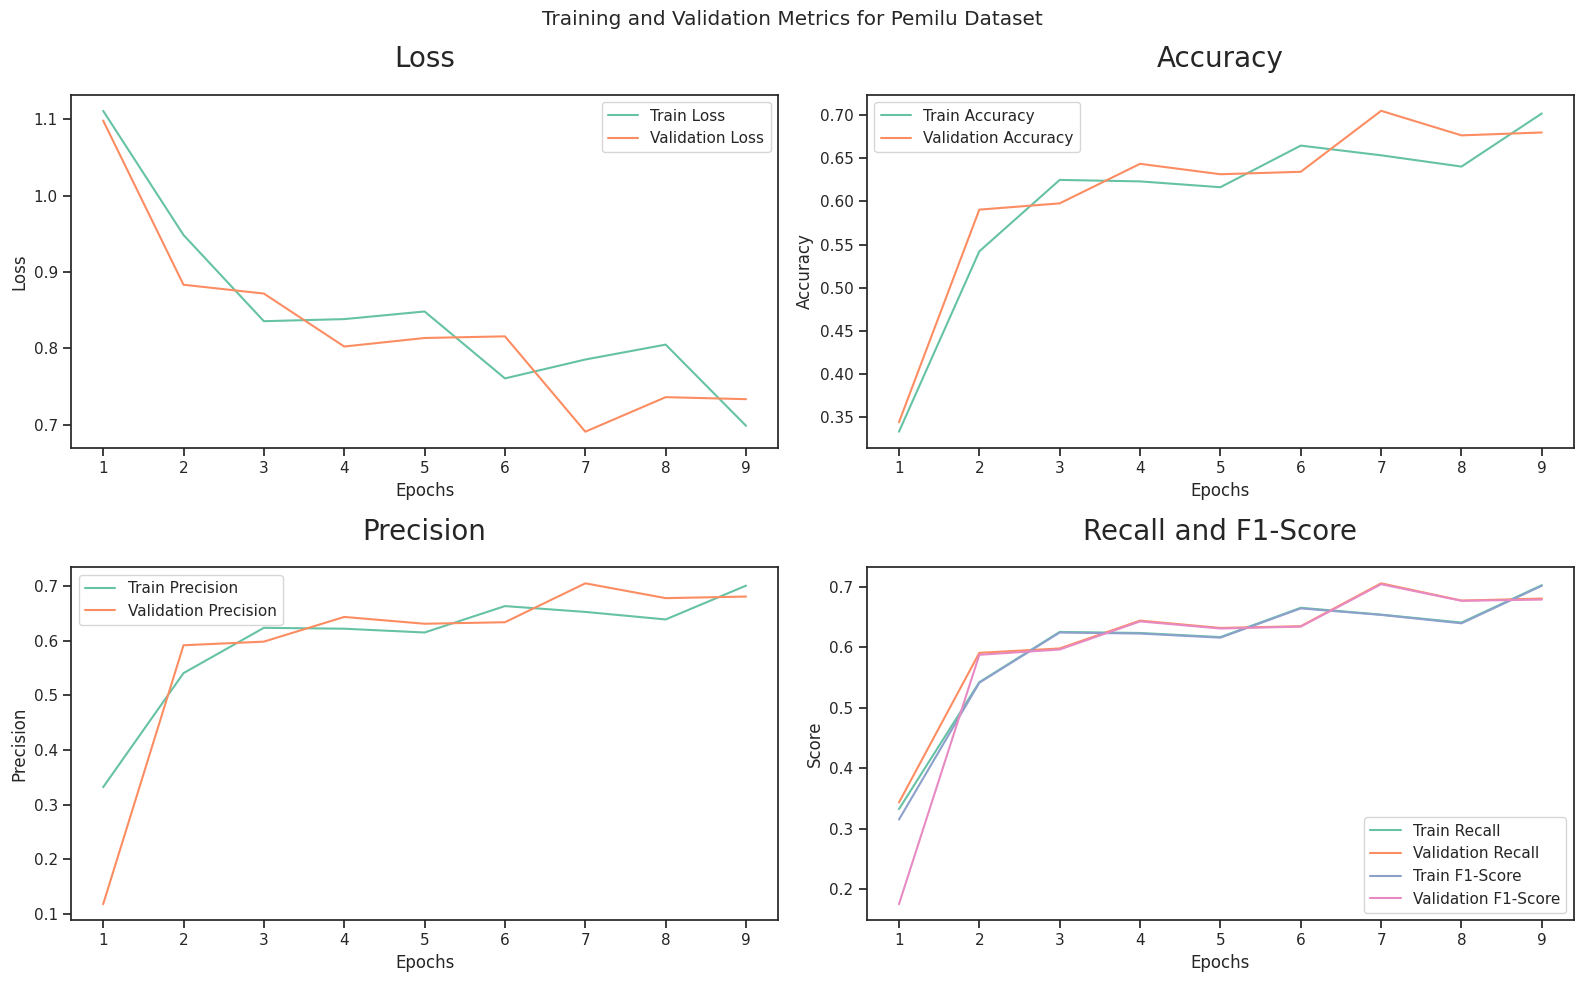

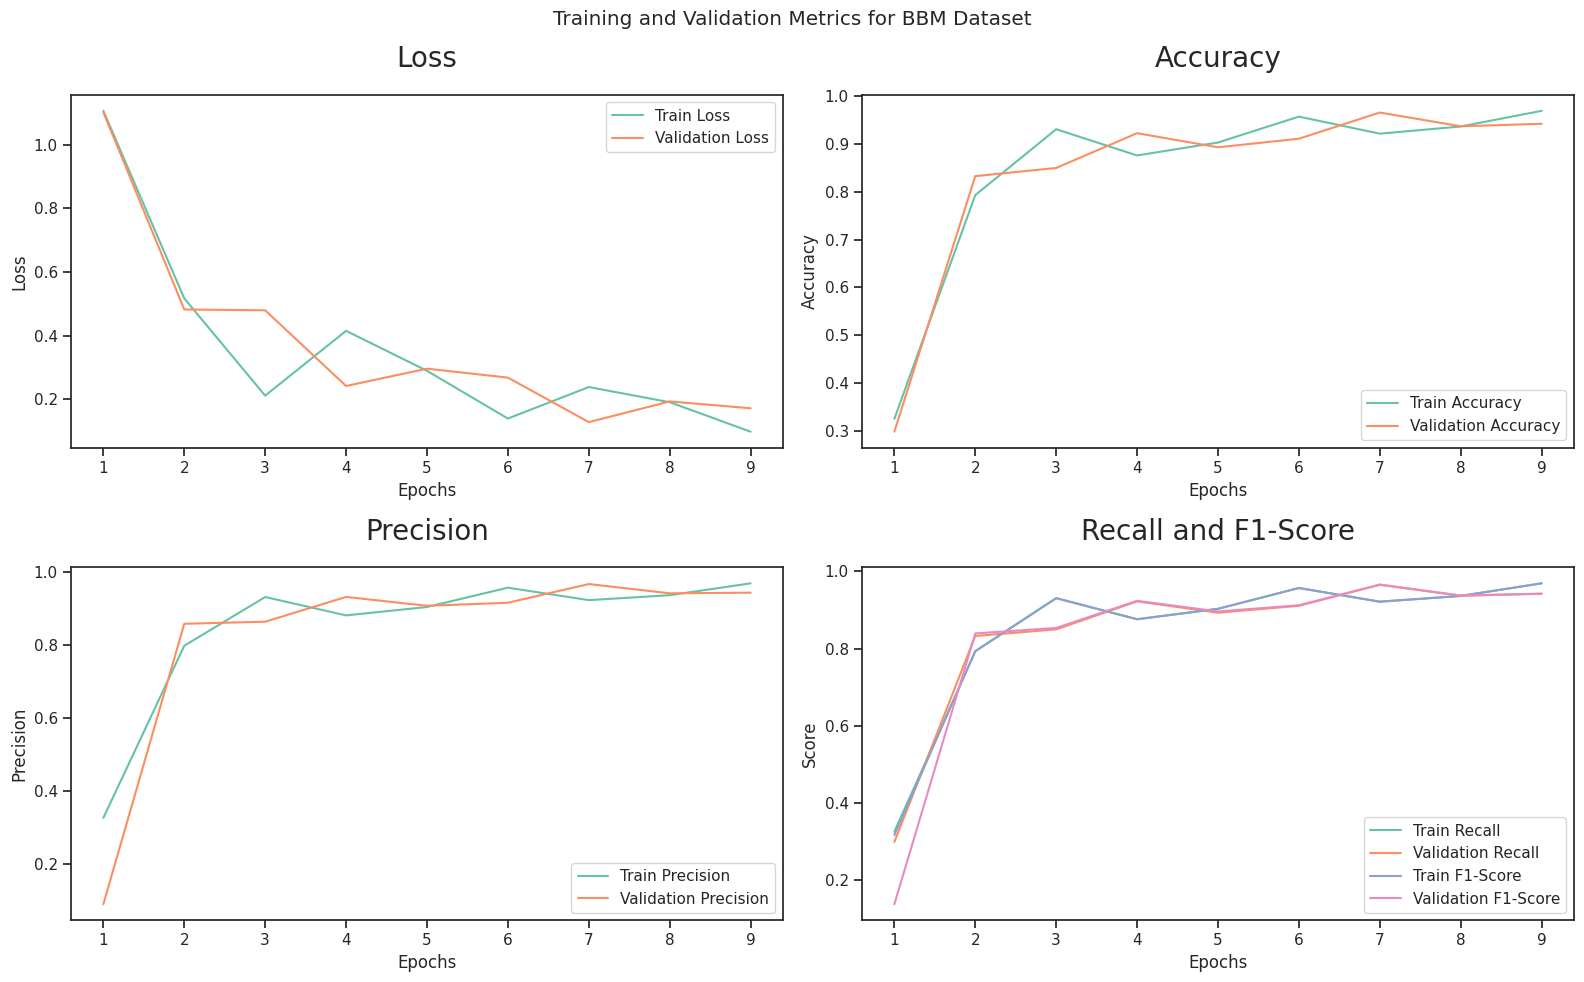

In [29]:
# Plot the history for both datasets
plot_history(history_pemilu, "Training and Validation Metrics for Pemilu Dataset"),
plot_history(history_bbm, "Training and Validation Metrics for BBM Dataset")